In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

import torch
import torch.nn as nn

In [143]:
import sys
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader/utility')
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader')
from XTBClient.api import XTBClient, PERIOD
from utility import utility 

def get_data_for_symbol(symbol):
    c = XTBClient()
    c.login(os.environ.get("XTB_user_num"), os.environ.get("XTB_pass"))
    df = c.get_candles_in_range(symbol, PERIOD.FIVE_MINUTES.value, start=datetime.now() - timedelta(days=150))
    c.logout()
    
    df = df.reset_index()
    df.rename(columns={"timestamp": "date"}, inplace=True)
    
    df['date'] = df['date'].apply(pd.to_datetime)
    df.set_index('date',inplace=True)
    df.drop([col for col in df.columns if col != "close"], axis=1, inplace=True)
    return df


# def yf_get_data_for_symbol(symbol):
    # df = utility.collect_yf("EURUSD=x", "1mo", "1h")
    # df = df.reset_index()
    # df.rename(columns={"timestamp": "date"}, inplace=True)
    
    # df['date'] = df['date'].apply(pd.to_datetime)
    # df.set_index('date',inplace=True)
    # return df

In [3]:
df = get_data_for_symbol("EURUSD")
df

,open,close,high,low,volume
date,,,,,
2023-05-23 22:00:00,1.07716,1.07724,1.07730,1.07716,227.0
2023-05-23 22:05:00,1.07724,1.07710,1.07724,1.07700,193.0
2023-05-23 22:10:00,1.07710,1.07706,1.07711,1.07701,407.0
2023-05-23 22:15:00,1.07707,1.07707,1.07714,1.07704,416.0
2023-05-23 22:20:00,1.07708,1.07708,1.07712,1.07706,374.0
...,...,...,...,...,...
2023-06-29 00:50:00,1.09019,1.09040,1.09051,1.09004,2219.0
2023-06-29 00:55:00,1.09043,1.09065,1.09069,1.09030,1796.0
2023-06-29 01:00:00,1.09067,1.09075,1.09078,1.09055,2121.0


In [4]:
closed_prices = df["close"]

In [5]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [6]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [7]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [8]:
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [9]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
   

In [10]:
model = Model(1 , 64)


optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [11]:
num_epochs = 100
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.11490404
20 epoch loss 0.039181095
30 epoch loss 0.034719285
40 epoch loss 0.028634062
50 epoch loss 0.017279672
60 epoch loss 0.0044001723
70 epoch loss 0.0024585624
80 epoch loss 0.001719324
90 epoch loss 0.0013905038


In [12]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
index = df[int(0.8*len(df)+3):].index

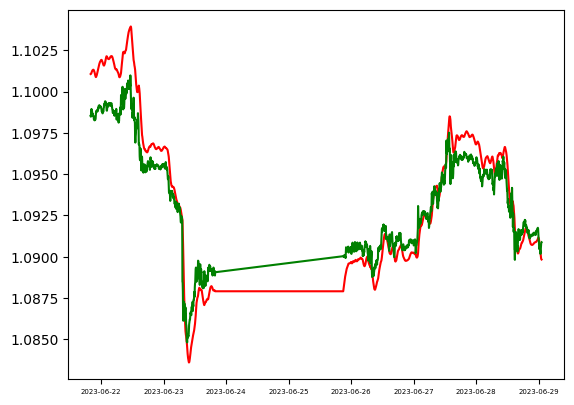

In [13]:
plt.plot(index, pred.squeeze() , color = "red" , label = "predicted")
plt.plot(index, real.squeeze() , color = "green" , label = "real")
plt.xticks(fontsize=5)
plt.show()

In [14]:
torch.save(model, "lstm_model")

In [15]:
trained_till = df[:train_x.shape[0]].index.max()

In [16]:
print("Model trained using data to: " + str(trained_till))

Model trained using data to: 2023-06-21 18:40:00


# Evaluation

In [17]:
df = get_data_for_symbol("EURUSD")

In [18]:
df = df[df.index > trained_till]

In [19]:
df

,open,close,high,low,volume
date,,,,,
2023-06-21 18:45:00,1.09862,1.09833,1.09862,1.09832,2866.0
2023-06-21 18:50:00,1.09833,1.09842,1.09848,1.09833,3289.0
2023-06-21 18:55:00,1.09841,1.09845,1.09848,1.09828,3517.0
2023-06-21 19:00:00,1.09842,1.09832,1.09844,1.09810,3014.0
2023-06-21 19:05:00,1.09832,1.09850,1.09855,1.09830,2302.0
...,...,...,...,...,...
2023-06-29 00:50:00,1.09019,1.09040,1.09051,1.09004,2219.0
2023-06-29 00:55:00,1.09043,1.09065,1.09069,1.09030,1796.0
2023-06-29 01:00:00,1.09067,1.09075,1.09078,1.09055,2121.0


In [104]:
model = torch.load("lstm_model")

In [105]:
model.eval()

Model(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [106]:
closed_prices = df["close"]

In [107]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [108]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [109]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [110]:
test_x = torch.from_numpy(X).float()
test_y = torch.from_numpy(y).float()

In [111]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
index = df.head(real.shape[0]).index

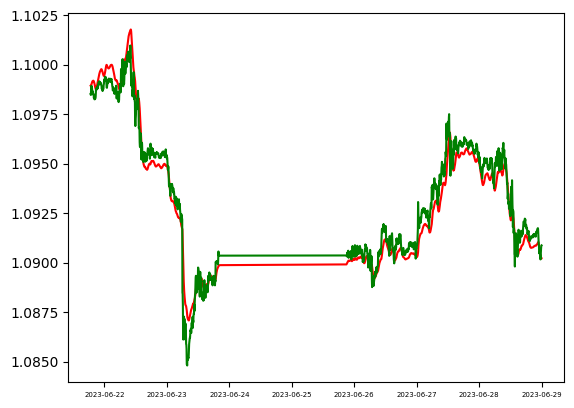

In [112]:
plt.plot(index, pred.squeeze() , color = "red" , label = "predicted")
plt.plot(index, real.squeeze() , color = "green" , label = "real")
plt.xticks(fontsize=5)
plt.show()

# Evaluation 2

In [144]:
df = get_data_for_symbol("EURUSD")
df = df[df.index > trained_till]

In [145]:
model = torch.load("lstm_model")

In [146]:
closed_prices = df["close"]

In [147]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [148]:
n_steps = 150 

In [149]:
input_seq = scaled_price[-seq_len:]

In [150]:
predictions = []

In [151]:
with torch.no_grad():
    for _ in range(n_steps):
        input_tensor = torch.from_numpy(np.array(input_seq)[-seq_len:].reshape(1, -1, 1)).float()

        output = model(input_tensor)
        prediction = mm.inverse_transform(output.numpy())[0][0]
        
        prediction = np.array(prediction).reshape(1, 1)
        prediction = mm.transform(prediction)[0][0]
        
        predictions.append(prediction)
        input_seq = np.append(input_seq[1:], prediction)


In [152]:
predictions = mm.inverse_transform(np.array(predictions).reshape(1,-1)).reshape(-1,1)

In [153]:
future_index = pd.date_range(start=df.index[-1], periods=n_steps+1, freq='5min')[1:]

In [154]:
predictions_df = pd.DataFrame(predictions, index=future_index, columns=['predicted_close'])

In [157]:
new_df = pd.concat([df, predictions_df], axis=0)

<AxesSubplot: >

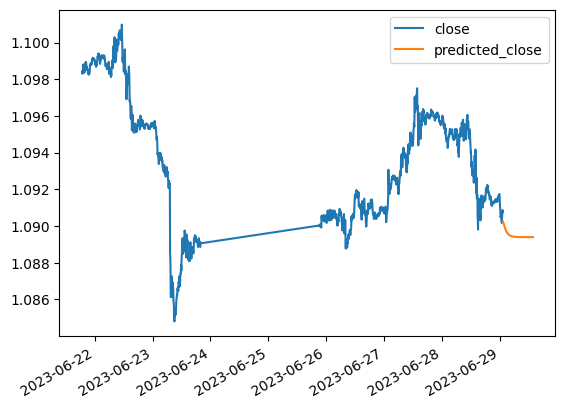

In [158]:
# plt.plot(index, real.squeeze(), color='green', label='real') 
# plt.plot(future_index, predictions, color='red', label='predicted')
# plt.xticks(fontsize=5)
# plt.legend()
# plt.show()
new_df[['close', 'predicted_close']].plot()

In [242]:

class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
    
class ForexPredictor:
    def __init__(self, symbol, period, interval, model_path):
        self.df = None
        self.symbol = symbol
        self.period = period
        self.interval = interval
        self.model_path = model_path
        self.trained_till = None
        self.model = None

    def train(self, df, seq_len=15):
        closed_prices = df["close"]

        seq_len = 15

        mm = MinMaxScaler()
        scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()
        
        
        X = []
        y = []

        for i in range(len(scaled_price) - seq_len):
            X.append(scaled_price[i : i + seq_len])
            y.append(scaled_price[i + seq_len])
            
            
        X = np.array(X)[... , None]
        y = np.array(y)[... , None]

        train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
        train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
        test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
        test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()




        model = Model(1 , 64)


        optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
        loss_fn = nn.MSELoss()

        num_epochs = 100
        for epoch in range(num_epochs):
            output = model(train_x)
            loss = loss_fn(output , train_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if epoch % 10 == 0 and epoch != 0:
                # print(epoch , "epoch loss" , loss.detach().numpy())

        model.eval()
        # torch.save(model, "ABC")
        self.model = model
        self.trained_till = df[:train_x.shape[0]].index.max()
        self.save_model()

    def save_model(self):
        torch.save(self.model, self.model_path)

    def load_model(self):
        try:
            return torch.load(self.model_path)
        except FileNotFoundError:
            print("First train the model")
            return None
    
    
    def predict(self, df, n_steps):
        if self.trained_till:
            df = df[df.index > self.trained_till]
            
        model = torch.load(self.model_path)
        
        closed_prices = df["close"]
        seq_len = 15

        mm = MinMaxScaler()
        scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()
        
        input_seq = scaled_price[-seq_len:]
        predictions = []
        with torch.no_grad():
            for _ in range(n_steps):
                input_tensor = torch.from_numpy(np.array(input_seq)[-seq_len:].reshape(1, -1, 1)).float()

                output = model(input_tensor)
                prediction = mm.inverse_transform(output.numpy())[0][0]

                prediction = np.array(prediction).reshape(1, 1)
                prediction = mm.transform(prediction)[0][0]

                predictions.append(prediction)
                input_seq = np.append(input_seq[1:], prediction)
                
                
        predictions = mm.inverse_transform(np.array(predictions).reshape(1,-1)).reshape(-1,1)
        future_index = pd.date_range(start=df.index[-1], periods=n_steps+1, freq='5min')[1:]
        
        
        predictions_df = pd.DataFrame(predictions, index=future_index, columns=['predicted_close'])
        
        new_df = pd.concat([df, predictions_df], axis=0)
        
        return new_df

In [243]:
fp = ForexPredictor("EURUSD", "1mo", "5m", "new_model")

In [244]:
df = get_data_for_symbol("EURUSD")

<AxesSubplot: xlabel='date'>

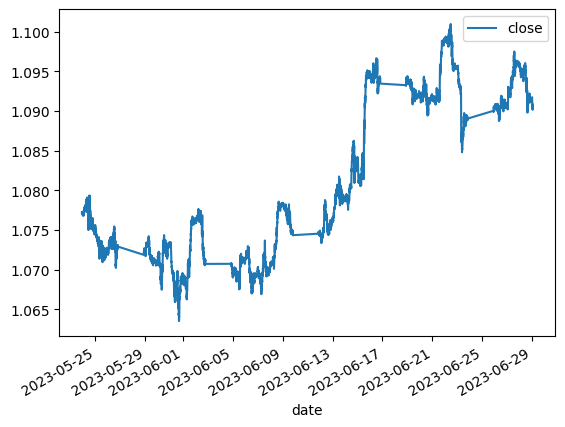

In [245]:
df[['close']].plot()

In [246]:
train = df[df.index < pd.to_datetime("2023-05-29 00:00:00")]
train

,close
date,
2023-05-23 22:00:00,1.07724
2023-05-23 22:05:00,1.07710
2023-05-23 22:10:00,1.07706
2023-05-23 22:15:00,1.07707
2023-05-23 22:20:00,1.07708
...,...
2023-05-28 23:35:00,1.07212
2023-05-28 23:40:00,1.07221
2023-05-28 23:45:00,1.07229


In [248]:
fp.train(train)

In [254]:
to_predict = df[df.index >= pd.to_datetime("2023-05-29 00:00:00")]
to_predict

,close
date,
2023-05-29 00:00:00,1.07203
2023-05-29 00:05:00,1.07174
2023-05-29 00:10:00,1.07188
2023-05-29 00:15:00,1.07190
2023-05-29 00:20:00,1.07186
...,...
2023-06-29 00:50:00,1.09040
2023-06-29 00:55:00,1.09065
2023-06-29 01:00:00,1.09075


In [255]:
new_df = fp.predict(df, 150)

In [258]:
new_df[new_df.predicted_close.notnull() ]

,close,predicted_close
2023-06-29 01:15:00,NaN,1.089281
2023-06-29 01:20:00,NaN,1.089141
2023-06-29 01:25:00,NaN,1.088987
2023-06-29 01:30:00,NaN,1.088816
2023-06-29 01:35:00,NaN,1.088639
...,...,...
2023-06-29 13:20:00,NaN,1.077625
2023-06-29 13:25:00,NaN,1.077625
2023-06-29 13:30:00,NaN,1.077625
2023-06-29 13:35:00,NaN,1.077625


<AxesSubplot: >

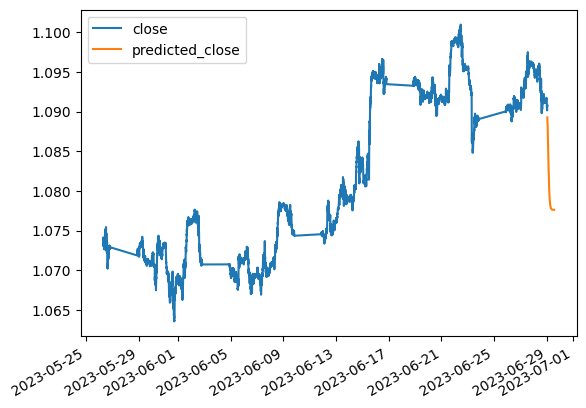

In [250]:
new_df[['close', 'predicted_close']].plot()